In [186]:
%load_ext autoreload
%autoreload 2

from xml.etree.ElementTree import Element, SubElement, ElementTree
from nxedit.xml_generator.utils import save_root_as_xml
from nxedit.xml_generator.xml_maker import prepare_header
import networkx as nx

import joblib


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [187]:
# node id should begin with Task_****

In [190]:

g=joblib.load("temp/g.bin")

In [222]:
"""
g=nx.DiGraph()
g.add_node("Task_1",node_name="start")
g.add_node("Task_2",node_name="middle")
g.add_node("Task_3",node_name="end")
g.add_node("Task_4",node_name="inter")
g.add_edge("Task_1","Task_2")
g.add_edge("Task_2","Task_3")
g.add_edge("Task_2","Task_4")
"""

'\ng=nx.DiGraph()\ng.add_node("Task_1",node_name="start")\ng.add_node("Task_2",node_name="middle")\ng.add_node("Task_3",node_name="end")\ng.add_node("Task_4",node_name="inter")\ng.add_edge("Task_1","Task_2")\ng.add_edge("Task_2","Task_3")\ng.add_edge("Task_2","Task_4")\n'

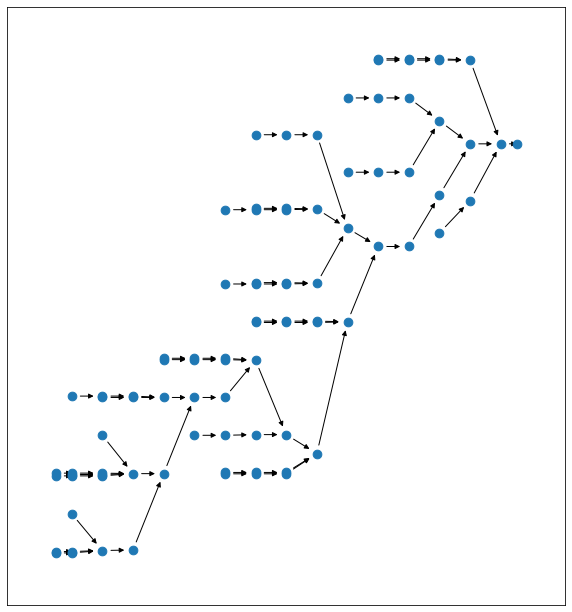

In [230]:
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
SCALE=5*10**-2
#n_pos=nx.spring_layout(g)
plt.figure(figsize=(10,11), facecolor="w", frameon=False)
n_pos = graphviz_layout(g, prog='dot', root=0, args='-Grankdir="LR" -Gnodesep=1 -Nshape="box" -Granksep=2 -Gsplines="ortho" ')
pos={}  

for k,v in n_pos.items():
    pos[k]=(str(int(v[0]*SCALE)),str(int(v[1]*SCALE)))

#print(pos)

nx.draw_networkx(g, n_pos, with_labels=False, node_shape='.')

In [258]:
def calc_tree_pos(g,
SCALE=5*10**-2,
width=100,
height=80,
y_ratio=1.5,
):


    #plt.figure(figsize=(10,15))
    original_pos = graphviz_layout(g, prog='dot', root=0, args='-Grankdir="LR" -Gnodesep=1 -Nshape="box" -Granksep=2 -Gsplines="ortho" ')

    #modify overlaps (nor perfect)
    modif_pos={}  
    for k,v in original_pos.items():
        modif_pos[k]=(((v[0]*SCALE)),((v[1]*SCALE*1.5)))



    def get_pos(modif_pos,node_id):
        x=modif_pos[node_id][0]
        y=modif_pos[node_id][1]
        return x,y



    for node_id in g.nodes:
        x,y=get_pos(modif_pos,node_id)
        for target_node_id in g.nodes:
            if node_id==target_node_id:
                continue

            tx,ty=get_pos(modif_pos,target_node_id)
            #check collision
            if x+width>tx and x<tx+width:
                if y+height>ty and y<ty+height:
                    modif_pos[target_node_id]=(tx,ty-height*y_ratio)


    pos={}  
    for k,v in modif_pos.items():
        pos[k]=(str(int(v[0])),str(int(v[1])))



    return pos

In [256]:
def graph_to_xml(g,pos,save_path):

    #header
    root=prepare_header()

    #main nodes
    process= Element("bpmn:process")

    #content
    root.append(process)
    process.set("id","Process_1")
    process.set("isExecutable","false")


    #view
    diagram=Element("bpmndi:BPMNDiagram")
    root.append(diagram)
    diagram.set("id","BPMNDiagram_1")
    plane=Element("bpmndi:BPMNPlane")
    diagram.append(plane)
    plane.set("id","BPMNPlane_1")
    plane.set("bpmnElement","Process_1")




    for node_id in g.nodes:
        #node content
        content=g.nodes[node_id]["node_name"]

        task= Element("bpmn:task")
        process.append(task)
        task.set("id",node_id)
        task.set("name",content)

        from_nodes= list(g.predecessors(node_id))
        to_nodes= list(g.successors(node_id))

        #edge 
        for from_node in from_nodes:
            #connect
            flow=Element("bpmn:sequenceFlow")
            process.append(flow)
            income=Element("bpmn:incoming")
            task.append(income)
            income.text=f"SequenceFlow-{from_node}:{node_id}"

            flow.set("id",f"SequenceFlow-{from_node}:{node_id}")
            flow.set("sourceRef",from_node)
            flow.set("targetRef",node_id)

            #view
            vedge=Element("bpmndi:BPMNEdge") 
            plane.append(vedge)
            vedge.set("id",f"SequenceFlow-{from_node}:{node_id}_di")
            vedge.set("bpmnElement",f"SequenceFlow-{from_node}:{node_id}")
            way=Element("di:waypoint")
            vedge.append(way)
            way.set("x",pos[node_id][0])
            way.set("y",pos[node_id][1])


        for to_node in to_nodes:
            #connect
            flow=Element("bpmn:sequenceFlow")
            process.append(flow)
            outgo=Element("bpmn:outgoing")
            task.append(outgo)
            outgo.text=f"SequenceFlow-{node_id}:{to_node}"

            flow.set("id",f"SequenceFlow-{node_id}:{to_node}")
            flow.set("sourceRef",node_id)
            flow.set("targetRef",to_node)      

            #view
            vedge=Element("bpmndi:BPMNEdge") 
            plane.append(vedge)
            vedge.set("id",f"SequenceFlow-{node_id}:{to_node}_di")
            vedge.set("bpmnElement",f"SequenceFlow-{node_id}:{to_node}")
            way=Element("di:waypoint")
            vedge.append(way)
            way.set("x",pos[node_id][0])
            way.set("y",pos[node_id][1])


    #view
    for node_id in g.nodes:
        content=g.nodes[node_id]["node_name"]
        shape= Element("bpmndi:BPMNShape")
        plane.append(shape)
        shape.set("id",node_id+"_di")
        shape.set("bpmnElement",node_id)

        bounds=Element("dc:Bounds")
        shape.append(bounds)
        bounds.set("x",pos[node_id][0])
        bounds.set("y",pos[node_id][1])
        bounds.set("height","80")
        bounds.set("width","100")




    save_root_as_xml(root,save_path)
